In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint
# Set seed for reproducibility
np.random.seed(42)
import warnings

warnings.filterwarnings("ignore")

In [2]:
class FormanRicci:
    def __init__(self, G):
        self.G = G.copy()

    def compute_ricci_curvature(self):
        """
        Compute the Forman-Ricci curvature for all edges and nodes in an undirected graph G.
        """
        if self.G.is_directed():
            raise ValueError("The graph must be undirected.")

        # Initialize a dictionary to store the curvature values
        curvature = {}

        # Iterate over all edges in the graph
        for u, v in self.G.edges():
            # Get the edge weight (default to 1 if not provided)
            w_e = self.G[u][v].get('weight', 1)

            # Get the node weights (default to 1 if not provided)
            w_u = self.G.nodes[u].get('weight', 1)
            w_v = self.G.nodes[v].get('weight', 1)

            # Initialize the summation terms
            sum_u = 0
            sum_v = 0

            # Sum over the edges adjacent to node u
            for _, u_neigh in self.G.edges(u):
                if u_neigh != v:
                    w_u_neigh = self.G[u][u_neigh].get('weight', 1)
                    sum_u += w_u / np.sqrt(w_e * w_u_neigh)

            # Sum over the edges adjacent to node v
            for _, v_neigh in self.G.edges(v):
                if v_neigh != u:
                    w_v_neigh = self.G[v][v_neigh].get('weight', 1)
                    sum_v += w_v / np.sqrt(w_e * w_v_neigh)

            # Calculate the Forman-Ricci curvature for the edge (u, v)
            F_e = w_e * (w_u / w_e + w_v / w_e - sum_u - sum_v)

            # Store the curvature value
            curvature[(u, v)] = F_e
            self.G[u][v]['formanCurvature'] = F_e

        # Calculate average Forman-Ricci curvature for each node
        for n in self.G.nodes():
            fcsum = 0
            if self.G.degree(n) != 0:
                for nbr in self.G.neighbors(n):
                    if 'formanCurvature' in self.G[n][nbr]:
                        fcsum += self.G[n][nbr]['formanCurvature']
                self.G.nodes[n]['formanCurvature'] = fcsum / self.G.degree(n)
            else:
                self.G.nodes[n]['formanCurvature'] = 0

        print("Forman curvature computation done.")
        return self.G

In [3]:
# Create graphs for four undirected networks:
n = 1000 # Number of nodes in the networks

# Erdős-Rényi graph
p_er = 0.003
G_er = nx.erdos_renyi_graph(n, p_er)

# Watts-Strogatz graph
k_ws = 5
p_ws = 0.5
G_ws = nx.watts_strogatz_graph(n, k_ws, p_ws)

# Power-law cluster graph
m_plc = 3
p_plc = 0.05
G_plc = nx.powerlaw_cluster_graph(n, m_plc, p_plc)

# Barabási-Albert graph
m_ba = 3
G_ba = nx.barabasi_albert_graph(n, m_ba)

Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.


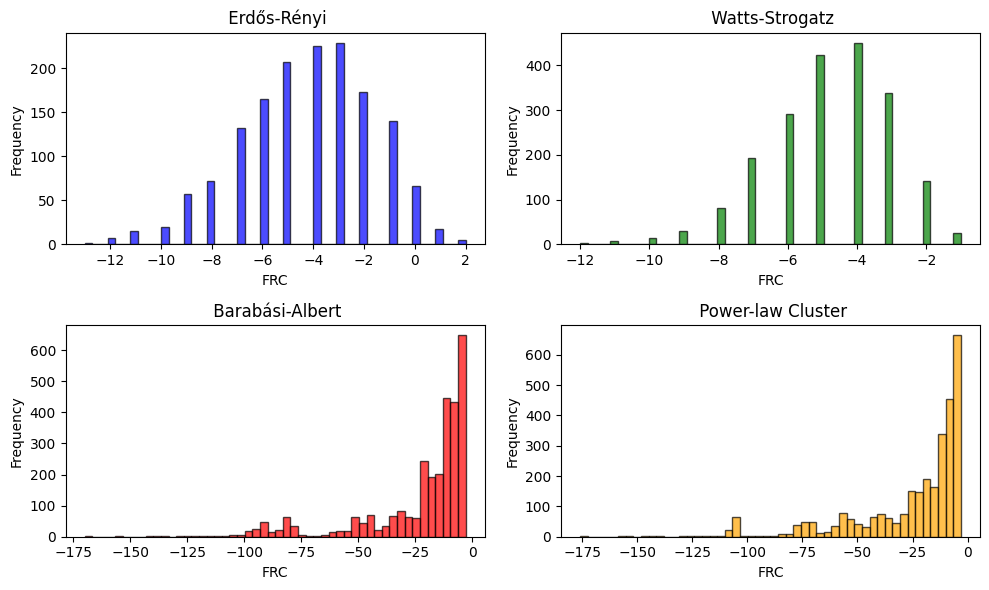

In [4]:
def plot_frc_distribution(G, model_name, ax, color):
    fr = FormanRicci(G)
    G_with_curvature = fr.compute_ricci_curvature()

    # Extract Forman-Ricci curvature values for all edges
    edge_curvatures = [G_with_curvature[u][v]['formanCurvature'] for u, v in G_with_curvature.edges()]

    # Plot histogram of Forman-Ricci curvature values with distinct color
    ax.hist(edge_curvatures, bins=50, alpha=0.7, color=color, edgecolor='black')
    ax.set_title(f' {model_name}')
    ax.set_xlabel('FRC')
    ax.set_ylabel('Frequency')
    #ax.grid(True)

# Plotting the Forman-Ricci Curvature distribution for each network with different colors
fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=100)

plot_frc_distribution(G_er, "Erdős-Rényi", axs[0, 0], color='blue')
plot_frc_distribution(G_ws, "Watts-Strogatz", axs[0, 1], color='green')
plot_frc_distribution(G_ba, "Barabási-Albert", axs[1, 0], color='red')
plot_frc_distribution(G_plc, "Power-law Cluster", axs[1, 1], color='orange')

plt.tight_layout()
plt.show()

In [5]:
def plot_curvature_vs_degree(G, model_name, ax):
    fr = FormanRicci(G)
    G_with_curvature = fr.compute_ricci_curvature()

    node_degrees = [G_with_curvature.degree(n) for n in G_with_curvature.nodes()]
    node_curvatures = [G_with_curvature.nodes[n]["formanCurvature"] for n in G_with_curvature.nodes()]

    corr, _ = pearsonr(node_curvatures, node_degrees)

    ax.scatter(node_curvatures, node_degrees, alpha=0.6, edgecolors='w', s=80, color='brown')
    ax.set_title(f'{model_name}\nR: {corr:.2f}')
    ax.set_xlabel('FRC')
    ax.set_ylabel('Node Degree')
    #ax.grid(True)

In [6]:
def plot_curvature_vs_clustering(G, model_name, ax):
    fr = FormanRicci(G)
    G_with_curvature = fr.compute_ricci_curvature()

    clustering_coeffs = nx.clustering(G_with_curvature)
    node_curvatures = [G_with_curvature.nodes[n]["formanCurvature"] for n in G_with_curvature.nodes()]

    clustering_values = [clustering_coeffs[n] for n in G_with_curvature.nodes()]
    corr, _ = pearsonr(node_curvatures, clustering_values)

    ax.scatter(node_curvatures, clustering_values, alpha=0.6, edgecolors='w', s=80)
    ax.set_title(f'{model_name:}\nR: {corr:.2f}')
    ax.set_xlabel('FRC')
    ax.set_ylabel('Clustering Coefficient')
    #ax.grid(True)

In [7]:
def plot_curvature_vs_betweenness(G, model_name, ax):
    fr = FormanRicci(G)
    G_with_curvature = fr.compute_ricci_curvature()

    betweenness_centrality = nx.betweenness_centrality(G_with_curvature)
    node_curvatures = [G_with_curvature.nodes[n]["formanCurvature"] for n in G_with_curvature.nodes()]

    betweenness_values = [betweenness_centrality[n] for n in G_with_curvature.nodes()]
    corr, _ = pearsonr(node_curvatures, betweenness_values)

    ax.scatter(node_curvatures, betweenness_values, alpha=0.6, edgecolors='w', s=80, color='green')
    ax.set_title(f'{model_name}\nR: {corr:.2f}')
    ax.set_xlabel('FRC')
    ax.set_ylabel('Betweenness Centrality')
    #ax.grid(True)

Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.


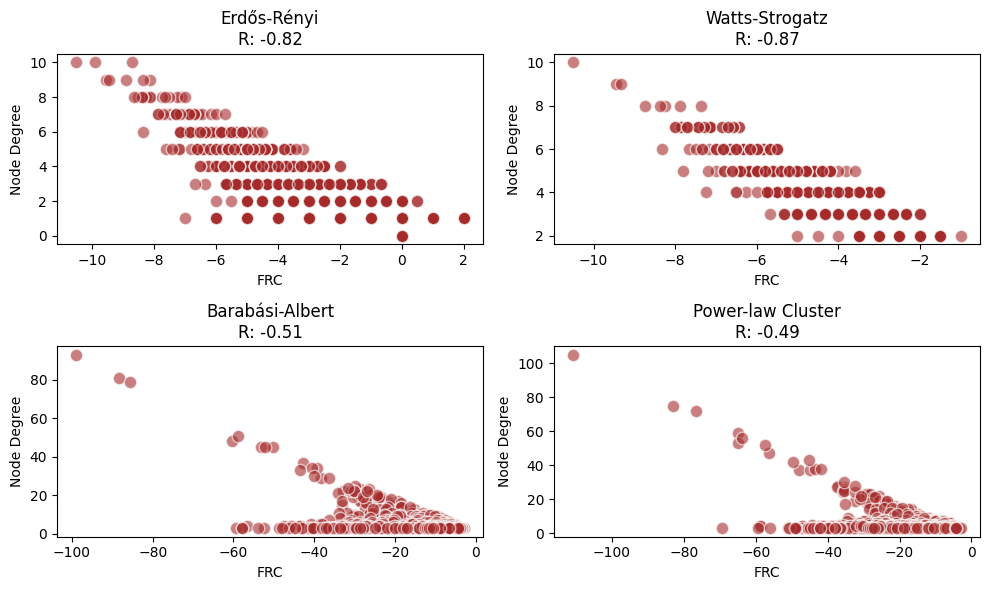

In [8]:
# Plotting of curvature_vs_degree
fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi = 100)

plot_curvature_vs_degree(G_er, "Erdős-Rényi", axs[0, 0])
plot_curvature_vs_degree(G_ws, "Watts-Strogatz", axs[0, 1])
plot_curvature_vs_degree(G_ba, "Barabási-Albert", axs[1, 0])
plot_curvature_vs_degree(G_plc, "Power-law Cluster", axs[1, 1])

plt.tight_layout()

plt.show()

Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.


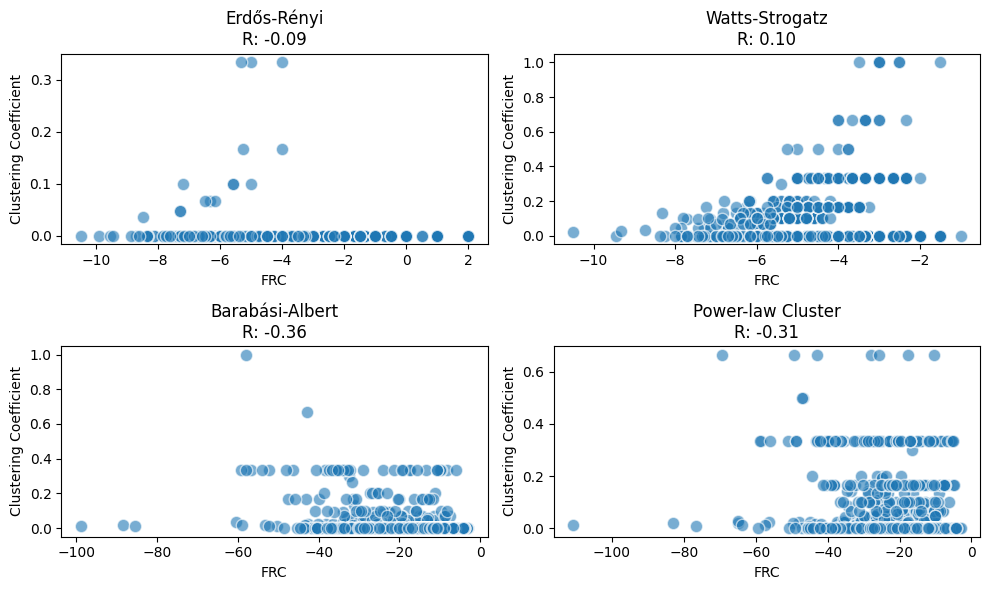

In [9]:
# Plotting for curvature_vs_clustering
fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi = 100)

plot_curvature_vs_clustering(G_er, "Erdős-Rényi", axs[0, 0])
plot_curvature_vs_clustering(G_ws, "Watts-Strogatz", axs[0, 1])
plot_curvature_vs_clustering(G_ba, "Barabási-Albert", axs[1, 0])
plot_curvature_vs_clustering(G_plc, "Power-law Cluster", axs[1, 1])
plt.tight_layout()
plt.show()

Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.


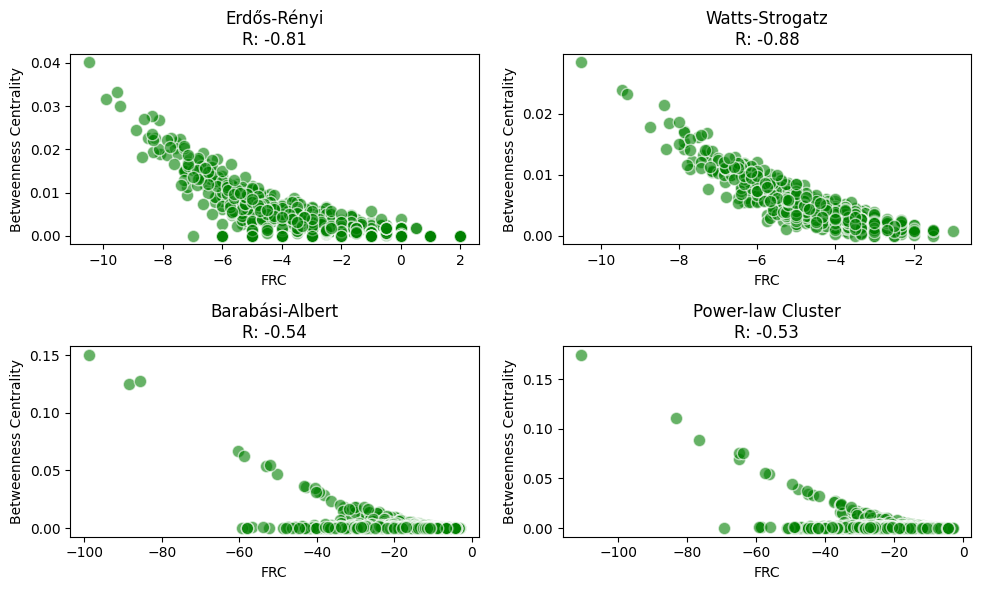

In [10]:
# Plotting of curvature_vs_betweenness
fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi = 100)

plot_curvature_vs_betweenness(G_er, "Erdős-Rényi", axs[0, 0])
plot_curvature_vs_betweenness(G_ws, "Watts-Strogatz", axs[0, 1])
plot_curvature_vs_betweenness(G_ba, "Barabási-Albert", axs[1, 0])
plot_curvature_vs_betweenness(G_plc, "Power-law Cluster", axs[1, 1])
plt.tight_layout()
#plt.tight_layout()
plt.show()

In [11]:
# SIR model function
def sir_model(y, t, beta, gamma, B, n):
    S, I, R = y[:n], y[n:2*n], y[2*n:]
    dSdt = -S * (B @ I)
    dIdt = S * (B @ I) - gamma * I
    dRdt = gamma * I
    return np.concatenate([dSdt, dIdt, dRdt])

In [12]:
# Run simulation on a network
def simulate_on_network(G, beta=0.5, gamma=0.1):
    fr = FormanRicci(G)
    G = fr.compute_ricci_curvature()
    node_list = list(G.nodes())
    node_to_index = {node: idx for idx, node in enumerate(node_list)}
    n = len(node_list)

    S0 = np.full(n, 0.9)
    I0 = np.full(n, 0.1)
    R0 = np.zeros(n)
    y0 = np.concatenate([S0, I0, R0])
    t = np.linspace(0, 100, 500)

    B = np.zeros((n, n))
    for u, v in G.edges():
        frc = G[u][v].get('formanCurvature', 0.0)
        i, j = node_to_index[u], node_to_index[v]
        B[i, j] = beta * np.exp(frc)
        B[j, i] = beta * np.exp(frc)

    np.fill_diagonal(B, 0)
    sol = odeint(sir_model, y0, t, args=(beta, gamma, B, n))
    S, I, R = sol[:, :n], sol[:, n:2*n], sol[:, 2*n:]
    return t, np.mean(S, axis=1) * n, np.mean(I, axis=1) * n, np.mean(R, axis=1) * n

In [13]:
# Define networks
networks = {
    "Erdős–Rényi": nx.erdos_renyi_graph(n=1000, p=0.003),
    "Watts-Strogatz": nx.watts_strogatz_graph(n=1000, k=5, p=0.5),
    "Barabási-Albert": nx.barabasi_albert_graph(n=1000, m=3),
    "Power-law Cluster": nx.powerlaw_cluster_graph(n=1000, m=3, p=0.05)
}

Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.


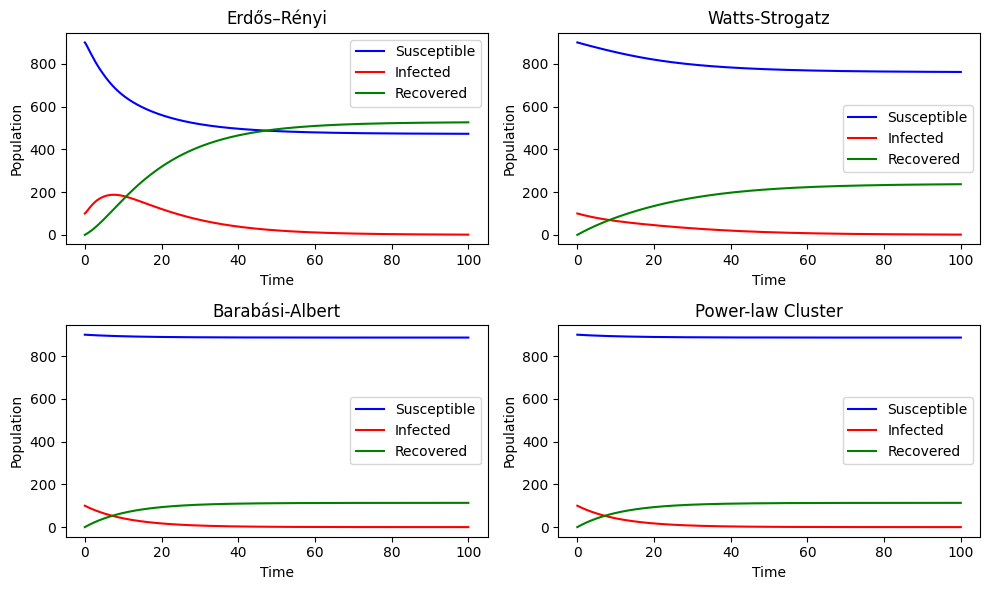

In [14]:
# Plot simulation results
fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=100)
axes = axes.flatten()

for i, (name, G) in enumerate(networks.items()):
    t, S, I, R = simulate_on_network(G)
    axes[i].plot(t, S, label='Susceptible', color='blue')
    axes[i].plot(t, I, label='Infected', color='red')
    axes[i].plot(t, R, label='Recovered', color='green')
    axes[i].set_title(name)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Population')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [15]:
# Simulation function
def simulate_sir_model_single_class(G, model_name, beta=0.5, gamma=0.1):
    fr = FormanRicci(G)
    G = fr.compute_ricci_curvature()
    node_list = list(G.nodes())
    node_to_index = {node: idx for idx, node in enumerate(node_list)}
    n = len(node_list)

    S0 = np.full(n, 0.9)
    I0 = np.full(n, 0.1)
    R0 = np.zeros(n)
    initial_conditions = np.concatenate([S0, I0, R0])

    t = np.linspace(0, 100, 500)

    B = np.zeros((n, n))
    for u, v in G.edges():
        frc = G[u][v].get('formanCurvature', 0.0)
        i, j = node_to_index[u], node_to_index[v]
        B[i, j] = beta * np.exp(frc)
        B[j, i] = beta * np.exp(frc)
    np.fill_diagonal(B, 0)

    sol = odeint(sir_model, initial_conditions, t, args=(beta, gamma, B, n))
    S, I, R = sol[:, :n], sol[:, n:2*n], sol[:, 2*n:]
    I_total = np.mean(I, axis=1) * n

    return t, I_total

Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.
Forman curvature computation done.


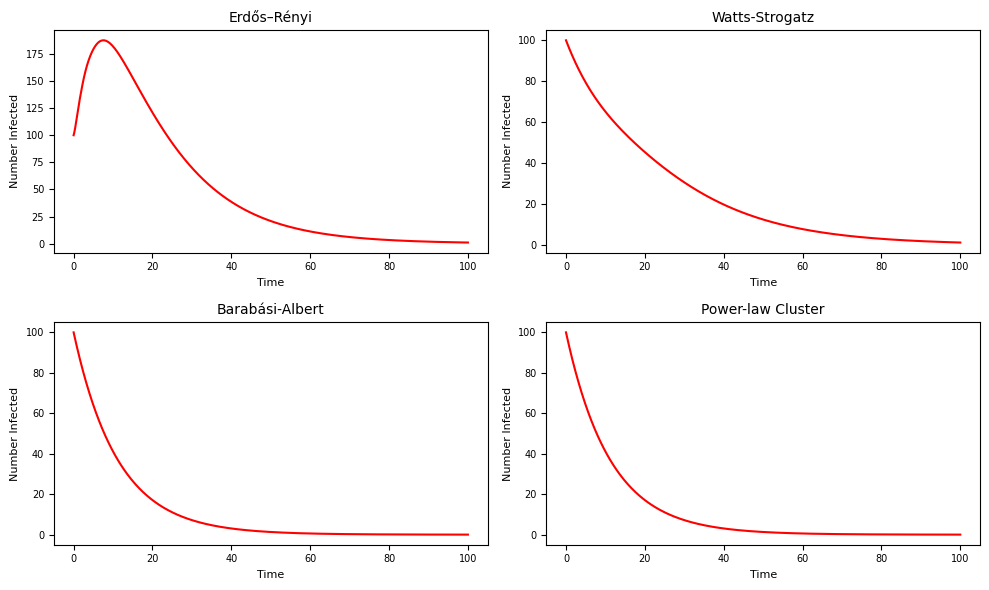

In [16]:
# Run simulations and plot
networks = networks
fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=100)
axs = axs.flatten()

for idx, (name, G) in enumerate(networks.items()):
    t, I_total = simulate_sir_model_single_class(G, name)
    axs[idx].plot(t, I_total, color='r')
    axs[idx].set_title(name, fontsize=10)
    axs[idx].set_xlabel('Time', fontsize=8)
    axs[idx].set_ylabel('Number Infected', fontsize=8)
    axs[idx].tick_params(labelsize=7)

plt.tight_layout()
plt.show()